# Phase 3: Downscaled Comprehensive Denoising Method Evaluation

## Research Objective
Systematically evaluate 3 denoising methods across 4 dimensions to determine optimal approaches for smartphone-based sleep apnea detection under realistic noise conditions using **downscaled sampling for faster execution**.

## This Notebook:
1. **Downscaled Sampling Focus**: Evaluate **20 randomly sampled files per condition** for rapid prototyping
2. **Multi-Method Denoising**: Apply 3 denoising techniques to representative priority conditions
3. **Four-Dimensional Evaluation**: Performance recovery, signal quality, computational efficiency, feature preservation
4. **Smartphone Suitability Scoring**: Weighted composite metrics for deployment decisions
5. **Method Ranking**: Evidence-based recommendations for mobile health applications

## Denoising Methods Under Evaluation:
- **Spectral Subtraction**: Fast, lightweight, potential musical noise artifacts
- **Wiener Filtering**: Balanced statistical approach with moderate complexity
- **LogMMSE**: Advanced statistical method with better artifact control

## Representative Test Conditions (5dB SNR - Worst Case):
- **patient_01_wav_5db_vacuum_cleaner**: Mechanical high-frequency noise
- **patient_01_wav_5db_cat**: Animal organic sounds
- **patient_01_wav_5db_door_wood_creaks**: Structural low-frequency noise
- **patient_01_wav_5db_crying_baby**: Human vocal interference
- **patient_01_wav_5db_coughing**: Respiratory interference (most challenging)

## Downscaled Optimization:
- **Sample Size**: 20 randomly selected files per condition (vs 1,168 full dataset)
- **Total Evaluations**: 5 conditions × 3 methods = 15 evaluations (~30 minutes)
- **Strategy**: Rapid prototyping and method comparison for proof-of-concept
- **Scientific Validity**: Random sampling maintains representativeness for comparative analysis

## Expected Outcomes:
- Recovery targets: 50% (minimum), 75% (good), 90% (excellent), 100% (perfect)
- Computational trade-offs: Traditional signal processing methods comparison
- Feature preservation analysis: Which methods maintain breathing biomarkers
- Smartphone deployment recommendations: Optimal method per use case

---

In [9]:
# Cell 1: Imports and Configuration
print("=== Phase 3: Downscaled Comprehensive Denoising Method Evaluation ===")

import os
import time
import json
import subprocess
import sys
import psutil
import numpy as np
import pandas as pd
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from scipy import stats
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    precision_score, recall_score, accuracy_score
)
import joblib
import random
import shutil
warnings.filterwarnings('ignore')

# Configuration paths
BASE_DATA_DIR = "F:/Solo All In One Docs/Scidb Sleep Data/processed"
MODEL_PATH = "../models/sleep_apnea_model.pkl"
PHASE2_RESULTS_PATH = os.path.join(BASE_DATA_DIR, "noise_evaluation_results.csv")
PHASE3_CONFIG_PATH = os.path.join(BASE_DATA_DIR, "phase3_preparation_config.json")
CLEAN_BASELINE_PATH = os.path.join(BASE_DATA_DIR, "clean_audio_baseline_results.json")

# Denoising methods configuration (3 traditional methods for speed)
DENOISING_METHODS = {
    'spectral_subtraction': {
        'script': '../src/spec_subtraction_same_file.py',
        'name': 'Spectral Subtraction',
        'category': 'traditional',
        'expected_efficiency': 'high',
        'expected_quality': 'moderate'
    },
    'wiener_filtering': {
        'script': '../src/wiener_filtering.py',
        'name': 'Wiener Filtering',
        'category': 'traditional',
        'expected_efficiency': 'high',
        'expected_quality': 'good'
    },
    'logmmse': {
        'script': '../src/log_mmse.py',
        'name': 'LogMMSE',
        'category': 'traditional',
        'expected_efficiency': 'moderate',
        'expected_quality': 'good'
    },
    'deepfilternet': {
    'script': '../src/denoise_with_deepfilternet.py',
    'name': 'DeepFilterNet',
    'category': 'deep_learning',
    'expected_efficiency': 'low',
    'expected_quality': 'excellent'
}
}

# Representative conditions from Phase 2 (5dB worst-case analysis)
REPRESENTATIVE_CONDITIONS = [
    'patient_01_wav_5db_vacuum_cleaner',    # Mechanical high-frequency noise
    'patient_01_wav_5db_cat',               # Animal organic sounds  
    'patient_01_wav_5db_door_wood_creaks',  # Structural low-frequency noise
    'patient_01_wav_5db_crying_baby',       # Human vocal interference
    'patient_01_wav_5db_coughing'           # Respiratory interference
]

# Audio processing settings (consistent with Phase 1 & 2)
TARGET_SAMPLE_RATE = 16000
FRAME_DURATION = 30.0

# DOWNSCALED SAMPLING CONFIGURATION
SAMPLE_SIZE_PER_CONDITION = 20  # Fixed 20 files per condition
RANDOM_SEED = 42  # For reproducible sampling

# Create output directories
DENOISED_OUTPUT_DIR = os.path.join(BASE_DATA_DIR, "denoised_audio_downscaled")
RESULTS_OUTPUT_DIR = os.path.join(BASE_DATA_DIR, "phase3_downscaled_results")
os.makedirs(DENOISED_OUTPUT_DIR, exist_ok=True)
os.makedirs(RESULTS_OUTPUT_DIR, exist_ok=True)

print(f"✅ Configuration loaded:")
print(f"   📁 Base data directory: {BASE_DATA_DIR}")
print(f"   🤖 Model path: {MODEL_PATH}")
print(f"   🔊 Denoising methods: {len(DENOISING_METHODS)} traditional methods")
print(f"   📊 Representative conditions: {len(REPRESENTATIVE_CONDITIONS)}")
print(f"   📊 Output directories created")
print(f"   ⚡ DOWNSCALED OPTIMIZATION: {SAMPLE_SIZE_PER_CONDITION} files per condition")
print(f"   🎯 Total evaluations: {len(REPRESENTATIVE_CONDITIONS)} × {len(DENOISING_METHODS)} = {len(REPRESENTATIVE_CONDITIONS) * len(DENOISING_METHODS)}")
print(f"   🚀 Expected execution time: ~30 minutes (vs 2+ hours full sampling)")

# Set random seed for reproducible sampling
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
print(f"   🎲 Random seed set: {RANDOM_SEED} (reproducible sampling)")

=== Phase 3: Downscaled Comprehensive Denoising Method Evaluation ===
✅ Configuration loaded:
   📁 Base data directory: F:/Solo All In One Docs/Scidb Sleep Data/processed
   🤖 Model path: ../models/sleep_apnea_model.pkl
   🔊 Denoising methods: 4 traditional methods
   📊 Representative conditions: 5
   📊 Output directories created
   ⚡ DOWNSCALED OPTIMIZATION: 20 files per condition
   🎯 Total evaluations: 5 × 4 = 20
   🚀 Expected execution time: ~30 minutes (vs 2+ hours full sampling)
   🎲 Random seed set: 42 (reproducible sampling)


In [10]:
# Feature extraction function (same 27 features as training pipeline)
def extract_comprehensive_features(audio_frame, sample_rate):
    """Extract the same 27 features used in training pipeline"""
    try:
        if len(audio_frame) == 0:
            return None
            
        # Basic acoustic features
        rms = float(librosa.feature.rms(y=audio_frame).mean())
        zcr = float(librosa.feature.zero_crossing_rate(y=audio_frame).mean())
        centroid = float(librosa.feature.spectral_centroid(y=audio_frame, sr=sample_rate).mean())
        bandwidth = float(librosa.feature.spectral_bandwidth(y=audio_frame, sr=sample_rate).mean())
        rolloff = float(librosa.feature.spectral_rolloff(y=audio_frame, sr=sample_rate).mean())
        
        # MFCCs (first 8 coefficients)
        mfccs = librosa.feature.mfcc(y=audio_frame, sr=sample_rate, n_mfcc=8)
        mfcc_means = mfccs.mean(axis=1)
        mfcc_stds = mfccs.std(axis=1)
        
        # Temporal features for breathing patterns (5-second windows)
        window_size = int(5 * sample_rate)  # 5 seconds
        num_windows = len(audio_frame) // window_size
        
        if num_windows >= 2:
            rms_windows = []
            zcr_windows = []
            
            for i in range(num_windows):
                start_idx = i * window_size
                end_idx = start_idx + window_size
                window = audio_frame[start_idx:end_idx]
                
                rms_windows.append(librosa.feature.rms(y=window).mean())
                zcr_windows.append(librosa.feature.zero_crossing_rate(y=window).mean())
            
            rms_variability = float(np.std(rms_windows))
            zcr_variability = float(np.std(zcr_windows))
            breathing_regularity = float(1.0 / (1.0 + rms_variability))  # Higher = more regular
        else:
            rms_variability = 0.0
            zcr_variability = 0.0
            breathing_regularity = 0.5
        
        # Silence detection
        silence_threshold = np.percentile(np.abs(audio_frame), 20)  # Bottom 20% as silence
        silence_mask = np.abs(audio_frame) < silence_threshold
        silence_ratio = float(np.mean(silence_mask))
        
        # Breathing pause detection (continuous silence periods)
        silence_changes = np.diff(silence_mask.astype(int))
        pause_starts = np.where(silence_changes == 1)[0]
        pause_ends = np.where(silence_changes == -1)[0]
        
        if len(pause_starts) > 0 and len(pause_ends) > 0:
            if len(pause_ends) < len(pause_starts):
                pause_ends = np.append(pause_ends, len(audio_frame))
            pause_durations = (pause_ends[:len(pause_starts)] - pause_starts) / sample_rate
            avg_pause_duration = float(np.mean(pause_durations))
            max_pause_duration = float(np.max(pause_durations))
        else:
            avg_pause_duration = 0.0
            max_pause_duration = 0.0
        
        # Combine all features (same structure as training)
        features = {
            'clean_rms': rms,
            'clean_zcr': zcr,
            'clean_centroid': centroid,
            'clean_bandwidth': bandwidth,
            'clean_rolloff': rolloff,
            'clean_rms_variability': rms_variability,
            'clean_zcr_variability': zcr_variability,
            'clean_breathing_regularity': breathing_regularity,
            'clean_silence_ratio': silence_ratio,
            'clean_avg_pause_duration': avg_pause_duration,
            'clean_max_pause_duration': max_pause_duration
        }
        
        # Add MFCCs
        for i, (mean_val, std_val) in enumerate(zip(mfcc_means, mfcc_stds), 1):
            features[f'clean_mfcc_{i}_mean'] = float(mean_val)
            features[f'clean_mfcc_{i}_std'] = float(std_val)
        
        return features
        
    except Exception as e:
        print(f"   ⚠️  Feature extraction error: {e}")
        return None

print("✅ Feature extraction function loaded (27 features matching training pipeline)")

✅ Feature extraction function loaded (27 features matching training pipeline)


In [11]:
# Cell 2: Load Phase 2 Results and Create Downscaled Sampling Function
print("📊 LOADING PHASE 2 RESULTS AND SETTING UP DOWNSCALED SAMPLING")
print(f"{'='*70}")

# Load Phase 2 evaluation results
try:
    phase2_results = pd.read_csv(PHASE2_RESULTS_PATH)
    print(f"✅ Phase 2 results loaded: {len(phase2_results)} noise conditions evaluated")
    
    # Display summary statistics
    print(f"\n📈 Phase 2 Performance Summary:")
    print(f"   F1-Score Range: {phase2_results['f1_score'].min():.3f} - {phase2_results['f1_score'].max():.3f}")
    print(f"   Average F1-Score: {phase2_results['f1_score'].mean():.3f} (±{phase2_results['f1_score'].std():.3f})")
    print(f"   Average Degradation: {phase2_results['f1_degradation_pct'].mean():.1f}% (±{phase2_results['f1_degradation_pct'].std():.1f}%)")
    
except Exception as e:
    print(f"❌ Could not load Phase 2 results: {e}")
    print(f"   Will proceed with fallback configuration")
    phase2_results = None

# Load clean baseline for reference
try:
    with open(CLEAN_BASELINE_PATH, 'r') as f:
        clean_baseline = json.load(f)
    print(f"\n✅ Clean baseline loaded: F1={clean_baseline['clean_f1_score']:.3f}")
except Exception as e:
    print(f"⚠️  Could not load clean baseline: {e}")
    clean_baseline = {'clean_f1_score': 0.672}  # Fallback value from research plan

# Downscaled sampling function for 20 files per condition
def sample_files_downscaled(input_dir, sample_size=20):
    """
    Randomly sample a fixed number of files from condition directory
    
    Args:
        input_dir: Directory containing audio files
        sample_size: Number of files to sample (default 20)
    
    Returns:
        List of sampled filenames (sorted for reproducibility)
    """
    try:
        all_files = [f for f in os.listdir(input_dir) if f.endswith('.wav')]
        
        if len(all_files) == 0:
            print(f"      ❌ No WAV files found in {input_dir}")
            return []
        
        if len(all_files) <= sample_size:
            print(f"      📊 Using all {len(all_files)} files (less than sample size)")
            return sorted(all_files)
        
        # Random sampling with fixed seed for reproducibility
        sampled_files = random.sample(all_files, sample_size)
        
        percentage_actual = (sample_size / len(all_files)) * 100
        print(f"      📊 Sampled {sample_size} files ({percentage_actual:.1f}%) from {len(all_files)} total files")
        
        return sorted(sampled_files)
        
    except Exception as e:
        print(f"      ❌ Sampling failed for {input_dir}: {e}")
        return []

def create_temp_sample_directory(source_dir, sampled_files, temp_suffix):
    """
    Create temporary directory with only sampled files for denoising
    
    Args:
        source_dir: Source directory containing all files
        sampled_files: List of filenames to copy
        temp_suffix: Unique suffix for temp directory
    
    Returns:
        Path to temporary directory
    """
    temp_dir = f"{source_dir}_temp_downscaled_{temp_suffix}"
    
    # Clean up any existing temp directory
    if os.path.exists(temp_dir):
        shutil.rmtree(temp_dir)
    
    os.makedirs(temp_dir, exist_ok=True)
    
    # Copy sampled files to temp directory
    copied_count = 0
    for filename in sampled_files:
        src = os.path.join(source_dir, filename)
        dst = os.path.join(temp_dir, filename)
        if os.path.exists(src):
            shutil.copy2(src, dst)
            copied_count += 1
    
    print(f"      📁 Created temp sample directory: {copied_count} files copied")
    return temp_dir

print(f"\n✅ Downscaled sampling functions loaded")
print(f"   📏 Sample size: {SAMPLE_SIZE_PER_CONDITION} files per condition")
print(f"   🎲 Random seed: {RANDOM_SEED} (reproducible results)")
print(f"   📁 Temporary directories will be created for each method-condition combination")

📊 LOADING PHASE 2 RESULTS AND SETTING UP DOWNSCALED SAMPLING
✅ Phase 2 results loaded: 5 noise conditions evaluated

📈 Phase 2 Performance Summary:
   F1-Score Range: 0.000 - 0.218
   Average F1-Score: 0.051 (±0.095)
   Average Degradation: 93.3% (±12.5%)

✅ Clean baseline loaded: F1=0.758

✅ Downscaled sampling functions loaded
   📏 Sample size: 20 files per condition
   🎲 Random seed: 42 (reproducible results)
   📁 Temporary directories will be created for each method-condition combination


In [12]:
# Cell 3: Select Priority Conditions and Prepare for Downscaled Evaluation
print("🎯 SELECTING PRIORITY CONDITIONS FOR DOWNSCALED EVALUATION")
print(f"{'='*60}")

# Select priority conditions for Phase 3 evaluation
priority_conditions = None

if phase2_results is not None:
    # Strategy: Select representative conditions across noise types at 5dB (worst-case)
    representative_conditions = []
    
    # Filter for 5dB conditions and get worst-performing per noise category
    conditions_5db = phase2_results[phase2_results['condition_name'].str.contains('_5db_')]
    
    if not conditions_5db.empty:
        for condition_name in REPRESENTATIVE_CONDITIONS:
            condition_match = conditions_5db[conditions_5db['condition_name'] == condition_name]
            if not condition_match.empty:
                representative_conditions.append(condition_match.iloc[0])
        
        if representative_conditions:
            priority_conditions = pd.DataFrame(representative_conditions)
            print(f"\n🎯 PRIORITY CONDITIONS SELECTED FOR DOWNSCALED EVALUATION:")
            print(f"📉 Representative Conditions (5dB worst-case per noise category):")
            for idx, row in priority_conditions.iterrows():
                print(f"   {row['condition_name']}: F1={row['f1_score']:.3f} (-{row['f1_degradation_pct']:.1f}%)")
        else:
            print(f"⚠️  No matching representative conditions found in Phase 2 results")
    else:
        print(f"⚠️  No 5dB conditions found in Phase 2 results")

if priority_conditions is None:
    print(f"⚠️  Using fallback representative conditions from configuration")
    # Create fallback priority conditions DataFrame
    priority_conditions = pd.DataFrame({
        'condition_name': REPRESENTATIVE_CONDITIONS,
        'f1_score': [0.400] * len(REPRESENTATIVE_CONDITIONS),  # Estimated based on 5dB degradation
        'f1_degradation_pct': [47.2] * len(REPRESENTATIVE_CONDITIONS)  # Estimated degradation
    })
    print(f"   Using {len(REPRESENTATIVE_CONDITIONS)} representative conditions as fallback")

# Verify condition directories exist and count available files
print(f"\n📁 VERIFYING CONDITION DIRECTORIES AND FILE COUNTS:")
verified_conditions = []

for _, condition_row in priority_conditions.iterrows():
    condition_name = condition_row['condition_name']
    condition_dir = os.path.join(BASE_DATA_DIR, condition_name)
    
    if os.path.exists(condition_dir):
        wav_files = [f for f in os.listdir(condition_dir) if f.endswith('.wav')]
        file_count = len(wav_files)
        
        if file_count > 0:
            verified_conditions.append(condition_row)
            sample_count = min(SAMPLE_SIZE_PER_CONDITION, file_count)
            print(f"   ✅ {condition_name}: {file_count} files available, will sample {sample_count}")
        else:
            print(f"   ❌ {condition_name}: No WAV files found")
    else:
        print(f"   ❌ {condition_name}: Directory not found at {condition_dir}")

if verified_conditions:
    priority_conditions = pd.DataFrame(verified_conditions)
    
    # Save priority conditions for reference
    priority_conditions_path = os.path.join(RESULTS_OUTPUT_DIR, "downscaled_priority_conditions.csv")
    priority_conditions.to_csv(priority_conditions_path, index=False)
    print(f"\n💾 Verified priority conditions saved: {priority_conditions_path}")
    
    print(f"\n✅ Priority condition verification complete:")
    print(f"   📊 Verified conditions: {len(priority_conditions)}")
    print(f"   🎯 Sample size per condition: {SAMPLE_SIZE_PER_CONDITION} files")
    print(f"   📈 Total files to process: {len(priority_conditions) * SAMPLE_SIZE_PER_CONDITION * len(DENOISING_METHODS)}")
    print(f"   ⏱️  Estimated execution time: ~30 minutes")
    
else:
    print(f"❌ No verified conditions available for evaluation")
    print(f"   Please check that Phase 2 noise injection has been completed")
    priority_conditions = None

🎯 SELECTING PRIORITY CONDITIONS FOR DOWNSCALED EVALUATION

🎯 PRIORITY CONDITIONS SELECTED FOR DOWNSCALED EVALUATION:
📉 Representative Conditions (5dB worst-case per noise category):
   patient_01_wav_5db_vacuum_cleaner: F1=0.000 (-100.0%)
   patient_01_wav_5db_cat: F1=0.036 (-95.2%)
   patient_01_wav_5db_door_wood_creaks: F1=0.000 (-100.0%)
   patient_01_wav_5db_crying_baby: F1=0.000 (-100.0%)
   patient_01_wav_5db_coughing: F1=0.218 (-71.2%)

📁 VERIFYING CONDITION DIRECTORIES AND FILE COUNTS:
   ✅ patient_01_wav_5db_vacuum_cleaner: 1168 files available, will sample 20
   ✅ patient_01_wav_5db_cat: 1168 files available, will sample 20
   ✅ patient_01_wav_5db_door_wood_creaks: 1168 files available, will sample 20
   ✅ patient_01_wav_5db_crying_baby: 1168 files available, will sample 20


   ✅ patient_01_wav_5db_coughing: 1168 files available, will sample 20

💾 Verified priority conditions saved: F:/Solo All In One Docs/Scidb Sleep Data/processed\phase3_downscaled_results\downscaled_priority_conditions.csv

✅ Priority condition verification complete:
   📊 Verified conditions: 5
   🎯 Sample size per condition: 20 files
   📈 Total files to process: 400
   ⏱️  Estimated execution time: ~30 minutes


In [13]:
# Cell 4: Load Model and Prepare Evaluation Framework
print("🤖 LOADING MODEL AND PREPARING EVALUATION FRAMEWORK")
print(f"{'='*60}")

# Load trained model
try:
    model_data = joblib.load(MODEL_PATH)
    
    if isinstance(model_data, dict):
        model = model_data['model']
        feature_columns = model_data.get('feature_columns', None)
        print(f"✅ Model loaded from: {MODEL_PATH}")
        print(f"📊 Model type: {type(model).__name__}")
        if feature_columns:
            print(f"🎯 Expected features: {len(feature_columns)}")
    else:
        # Fallback if model is saved directly
        model = model_data
        feature_columns = None
        print(f"✅ Model loaded (direct): {MODEL_PATH}")
        print(f"📊 Model type: {type(model).__name__}")
        
except Exception as e:
    print(f"❌ Failed to load model: {e}")
    model = None
    feature_columns = None

# Performance evaluation function optimized for downscaled processing
def evaluate_denoised_audio_downscaled(denoised_audio_dir, condition_name, method_name, model, feature_columns, audio_metadata):
    """Evaluate model performance on denoised audio with downscaled sampling"""
    
    print(f"   📊 Evaluating: {method_name} on {condition_name}")
    
    try:
        # Get WAV files in the denoised directory
        if not os.path.exists(denoised_audio_dir):
            print(f"      ❌ Directory not found: {denoised_audio_dir}")
            return None
        
        wav_files = [f for f in os.listdir(denoised_audio_dir) if f.lower().endswith('.wav')]
        if not wav_files:
            print(f"      ❌ No WAV files found in {denoised_audio_dir}")
            return None
        
        print(f"      🎵 Processing {len(wav_files)} denoised audio files...")
        
        # Apply whitespace fix to metadata if available
        if audio_metadata is not None and 'wav_file' in audio_metadata.columns:
            audio_metadata['wav_file'] = audio_metadata['wav_file'].str.strip()
        
        # Extract features and get labels with progress monitoring
        features_list = []
        labels_list = []
        processed_count = 0
        failed_count = 0
        mismatch_count = 0
        
        for i, wav_file in enumerate(wav_files):
            try:
                # Load denoised audio
                wav_path = os.path.join(denoised_audio_dir, wav_file)
                audio_data, sr = librosa.load(wav_path, sr=TARGET_SAMPLE_RATE)
                
                # Extract features
                features = extract_comprehensive_features(audio_data, sr)
                if features is None:
                    failed_count += 1
                    continue
                
                # Get corresponding label from metadata
                original_filename = wav_file.replace('mixed_', '').replace('denoised_', '').strip()
                
                if audio_metadata is not None:
                    # Find matching metadata record
                    metadata_match = audio_metadata[audio_metadata['wav_file'] == original_filename]
                    if not metadata_match.empty:
                        label = metadata_match.iloc[0]['apnea_label']
                        features_list.append(features)
                        labels_list.append(label)
                        processed_count += 1
                    else:
                        mismatch_count += 1
                        if mismatch_count <= 2:  # Show first 2 mismatches
                            print(f"      ⚠️  No metadata match for: '{original_filename}'")
                else:
                    failed_count += 1
                    
            except Exception as e:
                failed_count += 1
                if failed_count <= 2:  # Show first 2 errors
                    print(f"      ⚠️  Error processing {wav_file}: {e}")
        
        # Final summary
        print(f"      📊 Processed: {processed_count}, Failed: {failed_count}, Mismatches: {mismatch_count}")
        
        if processed_count == 0:
            print(f"      ❌ No files processed successfully")
            return None
        
        # Convert to DataFrame and make predictions
        features_df = pd.DataFrame(features_list)
        labels = np.array(labels_list)
        
        # Ensure feature order matches training
        if feature_columns:
            features_df = features_df.reindex(columns=feature_columns, fill_value=0)
        
        # Make predictions
        predictions = model.predict(features_df)
        prediction_probas = model.predict_proba(features_df)
        
        # Calculate comprehensive metrics
        f1 = f1_score(labels, predictions)
        precision = precision_score(labels, predictions)
        recall = recall_score(labels, predictions)  # Sensitivity
        accuracy = accuracy_score(labels, predictions)
        
        # Confusion matrix for specificity
        cm = confusion_matrix(labels, predictions)
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        
        results = {
            'condition_name': condition_name,
            'method_name': method_name,
            'num_samples': processed_count,
            'f1_score': f1,
            'precision': precision,
            'recall_sensitivity': recall,
            'specificity': specificity,
            'accuracy': accuracy,
            'confusion_matrix': cm.tolist(),
            'tp': int(tp), 'tn': int(tn), 'fp': int(fp), 'fn': int(fn),
            'sample_size_note': 'downscaled_20_files'
        }
        
        print(f"      ✅ {method_name}: F1={f1:.3f}, Sens={recall:.3f}, Spec={specificity:.3f} [n={processed_count}]")
        
        return results
        
    except Exception as e:
        print(f"      ❌ Evaluation failed: {e}")
        return None

# Computational efficiency measurement function for downscaled processing
def measure_denoising_efficiency_downscaled(input_dir, output_dir, method_script, method_name):
    """Measure computational efficiency of denoising method on downscaled sample"""
    
    print(f"   ⏱️  Measuring efficiency for {method_name}")
    
    try:
        # Get input file count
        input_files = [f for f in os.listdir(input_dir) if f.lower().endswith('.wav')]
        print(f"      📁 Input files to process: {len(input_files)}")
        
        # Get system resources before
        process = psutil.Process()
        memory_before = process.memory_info().rss / 1024 / 1024  # MB
        
        # Measure processing time
        start_time = time.time()
        print(f"      🚀 Starting denoising at {time.strftime('%H:%M:%S')}")
        
        # Run denoising method
        cmd = [sys.executable, method_script, '--input', input_dir, '--output', output_dir]
        
        result = subprocess.run(cmd, capture_output=True, text=True, timeout=300)  # 5 minute timeout
        
        end_time = time.time()
        processing_time = end_time - start_time
        
        print(f"      🏁 Processing completed in {processing_time:.1f}s")
        
        # Get system resources after
        memory_after = process.memory_info().rss / 1024 / 1024  # MB
        
        # Calculate efficiency metrics
        if os.path.exists(output_dir):
            output_files = [f for f in os.listdir(output_dir) if f.lower().endswith('.wav')]
            num_files_processed = len(output_files)
            
            # Estimate total audio duration (assuming 30-second files)
            total_audio_duration = num_files_processed * 30.0  # seconds
            real_time_factor = total_audio_duration / processing_time if processing_time > 0 else 0
            
            efficiency_metrics = {
                'method_name': method_name,
                'processing_time_sec': processing_time,
                'files_processed': num_files_processed,
                'total_audio_duration_sec': total_audio_duration,
                'real_time_factor': real_time_factor,
                'memory_usage_mb': memory_after - memory_before,
                'peak_memory_mb': memory_after,
                'processing_speed_files_per_sec': num_files_processed / processing_time if processing_time > 0 else 0,
                'success': result.returncode == 0,
                'sample_size_note': 'downscaled_20_files'
            }
            
            print(f"      ⚡ {method_name}: {processing_time:.1f}s, {real_time_factor:.2f}x RT, {num_files_processed} files")
            return efficiency_metrics
            
        else:
            print(f"      ❌ {method_name}: Output directory not created")
            return None
            
    except subprocess.TimeoutExpired:
        print(f"      ❌ {method_name}: Processing timeout (>5 minutes)")
        return None
    except Exception as e:
        print(f"      ❌ Efficiency measurement failed for {method_name}: {e}")
        return None

# Load audio metadata from Phase 1 for label matching
try:
    metadata_path = os.path.join(BASE_DATA_DIR, "audio_metadata.csv")
    if os.path.exists(metadata_path):
        audio_metadata = pd.read_csv(metadata_path)
        # Apply whitespace stripping immediately upon loading
        if 'wav_file' in audio_metadata.columns:
            audio_metadata['wav_file'] = audio_metadata['wav_file'].str.strip()
            print(f"✅ Audio metadata loaded: {len(audio_metadata)} records (whitespace cleaned)")
        else:
            print(f"✅ Audio metadata loaded: {len(audio_metadata)} records")
    else:
        print(f"⚠️  Audio metadata not found at {metadata_path}")
        audio_metadata = None
except Exception as e:
    print(f"⚠️  Could not load audio metadata: {e}")
    audio_metadata = None

print(f"\n✅ Evaluation framework ready for downscaled processing")
if model is None:
    print(f"⚠️  Model loading failed - evaluation will be limited")
if audio_metadata is None:
    print(f"⚠️  Audio metadata missing - label matching may fail")

🤖 LOADING MODEL AND PREPARING EVALUATION FRAMEWORK


✅ Model loaded (direct): ../models/sleep_apnea_model.pkl
📊 Model type: RandomForestClassifier
✅ Audio metadata loaded: 10972 records (whitespace cleaned)

✅ Evaluation framework ready for downscaled processing


In [14]:
# Cell 5: Apply Denoising Methods with Downscaled Processing
print("🔊 APPLYING DENOISING METHODS WITH DOWNSCALED PROCESSING")
print(f"Time started: {time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"{'='*80}")

def apply_and_evaluate_single_method_downscaled(condition_name, condition_row, method_key, method_config, 
                                              model, feature_columns, audio_metadata, clean_baseline):
    """Apply a single denoising method and evaluate performance with downscaled sampling"""
    
    method_name = method_config['name']
    method_script = method_config['script']
    
    print(f"   🔧 Applying {method_name} to {condition_name}...")
    
    try:
        # Find corresponding noisy audio directory
        noisy_audio_dir = os.path.join(BASE_DATA_DIR, condition_name)
        
        if not os.path.exists(noisy_audio_dir):
            print(f"      ❌ Noisy audio directory not found: {noisy_audio_dir}")
            return None, None
        
        # Apply downscaled sampling (20 files)
        sampled_files = sample_files_downscaled(noisy_audio_dir, SAMPLE_SIZE_PER_CONDITION)
        all_files_count = len([f for f in os.listdir(noisy_audio_dir) if f.lower().endswith('.wav')])
        
        if not sampled_files:
            print(f"      ❌ No files to sample from {noisy_audio_dir}")
            return None, None
            
        print(f"      📁 Processing {len(sampled_files)} sampled files (from {all_files_count} total)")
        
        # Create temporary directory with only sampled files
        temp_input_dir = create_temp_sample_directory(
            source_dir=noisy_audio_dir,
            sampled_files=sampled_files,
            temp_suffix=f"{method_key}_{int(time.time())}"
        )
        
        # Create output directory for this method-condition combination
        denoised_output_path = os.path.join(DENOISED_OUTPUT_DIR, f"{condition_name}_{method_key}")
        os.makedirs(denoised_output_path, exist_ok=True)
        
        # Check if denoising already completed (based on sampled files)
        efficiency_metrics = None
        existing_files = []
        
        if os.path.exists(denoised_output_path):
            existing_files = [f for f in os.listdir(denoised_output_path) if f.lower().endswith('.wav')]
            expected_output = [f for f in sampled_files if f.lower().endswith('.wav')]
            
            if len(existing_files) >= len(expected_output) * 0.8:  # 80% completion threshold
                print(f"      ✅ {method_name}: Already completed ({len(existing_files)} files)")
                efficiency_metrics = {
                    'method_name': method_name,
                    'condition_name': condition_name,
                    'processing_time_sec': None,  # Already completed
                    'files_processed': len(existing_files),
                    'success': True,
                    'note': 'Previously completed (downscaled)',
                    'total_files_available': all_files_count,
                    'sampled_files_count': len(sampled_files),
                    'sample_size_note': 'downscaled_20_files'
                }
            else:
                print(f"      🔄 {method_name}: Incomplete ({len(existing_files)}/{len(expected_output)}) - reprocessing")
        
        # Apply denoising method if needed
        if efficiency_metrics is None:
            efficiency_metrics = measure_denoising_efficiency_downscaled(
                input_dir=temp_input_dir,
                output_dir=denoised_output_path,
                method_script=method_script,
                method_name=method_name
            )
            
            # Add sampling metadata to efficiency metrics
            if efficiency_metrics:
                efficiency_metrics['condition_name'] = condition_name
                efficiency_metrics['total_files_available'] = all_files_count
                efficiency_metrics['sampled_files_count'] = len(sampled_files)
                efficiency_metrics['sampling_percentage'] = (len(sampled_files) / all_files_count) * 100
        
        # Clean up temporary directory
        try:
            if os.path.exists(temp_input_dir):
                shutil.rmtree(temp_input_dir)
                print(f"      🧹 Cleaned up temp directory")
        except Exception as cleanup_error:
            print(f"      ⚠️  Temp cleanup warning: {cleanup_error}")
        
        # Evaluate denoised audio performance
        performance_results = None
        if os.path.exists(denoised_output_path):
            performance_results = evaluate_denoised_audio_downscaled(
                denoised_audio_dir=denoised_output_path,
                condition_name=condition_name,
                method_name=method_name,
                model=model,
                feature_columns=feature_columns,
                audio_metadata=audio_metadata
            )
            
            if performance_results:
                # Add original noisy performance for comparison
                performance_results['original_f1'] = condition_row['f1_score']
                performance_results['original_degradation_pct'] = condition_row['f1_degradation_pct']
                
                # Calculate recovery metrics
                if clean_baseline:
                    clean_f1 = clean_baseline['clean_f1_score']
                    noisy_f1 = condition_row['f1_score']
                    denoised_f1 = performance_results['f1_score']
                    
                    # Recovery percentage: (denoised - noisy) / (clean - noisy) * 100
                    if clean_f1 > noisy_f1:
                        recovery_pct = (denoised_f1 - noisy_f1) / (clean_f1 - noisy_f1) * 100
                    else:
                        recovery_pct = 0
                    
                    performance_results['f1_recovery_pct'] = recovery_pct
                    performance_results['clean_baseline_f1'] = clean_f1
                
                # Add sampling metadata to performance results
                performance_results['total_files_available'] = all_files_count
                performance_results['sampled_files_count'] = len(sampled_files)
                performance_results['sampling_percentage'] = (len(sampled_files) / all_files_count) * 100
                
                print(f"      ✅ {method_name}: F1={performance_results['f1_score']:.3f}, Recovery={recovery_pct:.1f}% [Sample: {len(sampled_files)}/{all_files_count}]")
        
        return performance_results, efficiency_metrics
        
    except Exception as e:
        print(f"      ❌ {method_name} failed: {e}")
        return None, None

# Main downscaled processing execution
if priority_conditions is not None and model is not None:
    
    print(f"🚀 DOWNSCALED PROCESSING CONFIGURATION:")
    print(f"   🎯 Conditions: {len(priority_conditions)}")
    print(f"   🔧 Methods: {len(DENOISING_METHODS)}")
    print(f"   📊 Sample size: {SAMPLE_SIZE_PER_CONDITION} files per condition")
    print(f"   📈 Total evaluations: {len(priority_conditions) * len(DENOISING_METHODS)}")
    print(f"   ⏱️  Expected time: ~30 minutes")
    
    all_denoising_results = []
    all_efficiency_results = []
    start_time = time.time()
    
    # Process each condition sequentially (methods applied sequentially within each condition)
    for condition_idx, (_, condition_row) in enumerate(priority_conditions.iterrows()):
        condition_name = condition_row['condition_name']
        
        print(f"\n📍 Condition {condition_idx + 1}/{len(priority_conditions)}: {condition_name}")
        print(f"   📉 Original performance: F1={condition_row['f1_score']:.3f} (-{condition_row['f1_degradation_pct']:.1f}%)")
        
        condition_results = []
        condition_efficiency = []
        
        # Apply each denoising method to this condition
        for method_idx, (method_key, method_config) in enumerate(DENOISING_METHODS.items()):
            method_name = method_config['name']
            print(f"   🔧 Method {method_idx + 1}/{len(DENOISING_METHODS)}: {method_name}")
            
            performance_result, efficiency_result = apply_and_evaluate_single_method_downscaled(
                condition_name=condition_name,
                condition_row=condition_row,
                method_key=method_key,
                method_config=method_config,
                model=model,
                feature_columns=feature_columns,
                audio_metadata=audio_metadata,
                clean_baseline=clean_baseline
            )
            
            if performance_result:
                condition_results.append(performance_result)
                all_denoising_results.append(performance_result)
            if efficiency_result:
                condition_efficiency.append(efficiency_result)
                all_efficiency_results.append(efficiency_result)
        
        # Progress and timing
        elapsed = time.time() - start_time
        remaining_conditions = len(priority_conditions) - (condition_idx + 1)
        eta = (elapsed / (condition_idx + 1)) * remaining_conditions if condition_idx > 0 else 0
        
        print(f"   ✅ Condition completed: {len(condition_results)} methods successful")
        print(f"   ⏱️  Progress: {condition_idx + 1}/{len(priority_conditions)}, ETA: {eta/60:.1f} minutes")
    
    total_time = time.time() - start_time
    
    # Save results
    print(f"\n💾 Saving downscaled processing results...")
    
    if all_denoising_results:
        denoising_df = pd.DataFrame(all_denoising_results)
        denoising_results_path = os.path.join(RESULTS_OUTPUT_DIR, "downscaled_denoising_performance_results.csv")
        denoising_df.to_csv(denoising_results_path, index=False)
        print(f"💾 Denoising performance results saved: {denoising_results_path}")
    
    if all_efficiency_results:
        efficiency_df = pd.DataFrame(all_efficiency_results)
        efficiency_results_path = os.path.join(RESULTS_OUTPUT_DIR, "downscaled_denoising_efficiency_results.csv")
        efficiency_df.to_csv(efficiency_results_path, index=False)
        print(f"💾 Denoising efficiency results saved: {efficiency_results_path}")
    
    # Final summary
    print(f"\n{'='*80}")
    print(f"🏁 DOWNSCALED DENOISING APPLICATION COMPLETE!")
    print(f"⏱️  Total time: {total_time:.1f} seconds ({total_time/60:.1f} minutes)")
    print(f"📊 Performance evaluations: {len(all_denoising_results)}")
    print(f"⚡ Efficiency measurements: {len(all_efficiency_results)}")
    print(f"📏 Sample size per condition: {SAMPLE_SIZE_PER_CONDITION} files")
    print(f"🎯 Total combinations processed: {len(priority_conditions)} conditions × {len(DENOISING_METHODS)} methods")
    
    # Method ranking preview
    if all_denoising_results:
        results_df = pd.DataFrame(all_denoising_results)
        if 'f1_recovery_pct' in results_df.columns:
            method_rankings = results_df.groupby('method_name')['f1_recovery_pct'].mean().sort_values(ascending=False)
            print(f"\n🏆 PRELIMINARY METHOD RANKING (F1 Recovery):")
            for rank, (method, recovery) in enumerate(method_rankings.items(), 1):
                print(f"   {rank}. {method}: {recovery:.1f}% average recovery")
    
    # Set global variables for subsequent cells
    denoising_results = all_denoising_results
    efficiency_results = all_efficiency_results
    
else:
    if priority_conditions is None:
        print(f"⚠️  Priority conditions not available - check Phase 2 results")
    if model is None:
        print(f"⚠️  Model not loaded - cannot evaluate performance")
    
    denoising_results = []
    efficiency_results = []

print(f"\nTime finished: {time.strftime('%Y-%m-%d %H:%M:%S')}")

🔊 APPLYING DENOISING METHODS WITH DOWNSCALED PROCESSING
Time started: 2025-07-30 22:35:27
🚀 DOWNSCALED PROCESSING CONFIGURATION:
   🎯 Conditions: 5
   🔧 Methods: 4
   📊 Sample size: 20 files per condition
   📈 Total evaluations: 20
   ⏱️  Expected time: ~30 minutes

📍 Condition 1/5: patient_01_wav_5db_vacuum_cleaner
   📉 Original performance: F1=0.000 (-100.0%)
   🔧 Method 1/4: Spectral Subtraction
   🔧 Applying Spectral Subtraction to patient_01_wav_5db_vacuum_cleaner...
      📊 Sampled 20 files (1.7%) from 1168 total files
      📁 Processing 20 sampled files (from 1168 total)

Time started: 2025-07-30 22:35:27
🚀 DOWNSCALED PROCESSING CONFIGURATION:
   🎯 Conditions: 5
   🔧 Methods: 4
   📊 Sample size: 20 files per condition
   📈 Total evaluations: 20
   ⏱️  Expected time: ~30 minutes

📍 Condition 1/5: patient_01_wav_5db_vacuum_cleaner
   📉 Original performance: F1=0.000 (-100.0%)
   🔧 Method 1/4: Spectral Subtraction
   🔧 Applying Spectral Subtraction to patient_01_wav_5db_vacuum_clea

In [15]:
# Cell 6: Signal Quality Assessment (Downscaled)
print("📊 SIGNAL QUALITY ASSESSMENT - DOWNSCALED")
print(f"{'='*50}")

def calculate_snr(clean_audio, noisy_audio):
    """Calculate Signal-to-Noise Ratio in dB"""
    try:
        # Ensure same length
        min_len = min(len(clean_audio), len(noisy_audio))
        clean_audio = clean_audio[:min_len]
        noisy_audio = noisy_audio[:min_len]
        
        # Calculate signal and noise power
        signal_power = np.mean(clean_audio ** 2)
        noise_power = np.mean((noisy_audio - clean_audio) ** 2)
        
        if noise_power > 0:
            snr_db = 10 * np.log10(signal_power / noise_power)
        else:
            snr_db = float('inf')
        
        return snr_db
    except:
        return None

def calculate_spectral_distortion(clean_audio, processed_audio, sr=16000):
    """Calculate spectral distortion between clean and processed audio"""
    try:
        # Ensure same length
        min_len = min(len(clean_audio), len(processed_audio))
        clean_audio = clean_audio[:min_len]
        processed_audio = processed_audio[:min_len]
        
        # Compute spectrograms
        clean_spec = np.abs(librosa.stft(clean_audio))
        processed_spec = np.abs(librosa.stft(processed_audio))
        
        # Calculate L2 distance
        min_time = min(clean_spec.shape[1], processed_spec.shape[1])
        clean_spec = clean_spec[:, :min_time]
        processed_spec = processed_spec[:, :min_time]
        
        spectral_distance = np.sqrt(np.mean((clean_spec - processed_spec) ** 2))
        
        return spectral_distance
    except:
        return None

def assess_signal_quality_downscaled(condition_name, method_name, clean_dir, noisy_dir, denoised_dir, sample_size=10):
    """Assess signal quality improvement for downscaled method-condition combination"""
    
    print(f"   🔍 Assessing {method_name} on {condition_name}...")
    
    try:
        # Get sample files for analysis (use min between sample_size and available files)
        denoised_files = [f for f in os.listdir(denoised_dir) if f.lower().endswith('.wav')]
        sample_files = denoised_files[:min(sample_size, len(denoised_files))]
        
        snr_improvements = []
        spectral_distortions = []
        processed_files = 0
        
        for wav_file in sample_files:
            try:
                # Load denoised audio
                denoised_path = os.path.join(denoised_dir, wav_file)
                denoised_audio, sr = librosa.load(denoised_path, sr=TARGET_SAMPLE_RATE)
                
                # Find corresponding noisy and clean files
                noisy_path = os.path.join(noisy_dir, wav_file.replace('denoised_', '').replace('mixed_', 'mixed_'))
                
                # Try to find clean file (remove patient prefix from condition name)
                condition_parts = condition_name.split('_')
                patient_id = condition_parts[0] + '_' + condition_parts[1]  # e.g., 'patient_01'
                clean_filename = wav_file.replace('mixed_', '').replace('denoised_', '')
                clean_path = os.path.join(clean_dir, f"{patient_id}_wav", clean_filename)
                
                if os.path.exists(noisy_path):
                    noisy_audio, _ = librosa.load(noisy_path, sr=TARGET_SAMPLE_RATE)
                    
                    if os.path.exists(clean_path):
                        clean_audio, _ = librosa.load(clean_path, sr=TARGET_SAMPLE_RATE)
                        
                        # Calculate SNR improvement
                        noisy_snr = calculate_snr(clean_audio, noisy_audio)
                        denoised_snr = calculate_snr(clean_audio, denoised_audio)
                        
                        if noisy_snr is not None and denoised_snr is not None:
                            snr_improvement = denoised_snr - noisy_snr
                            snr_improvements.append(snr_improvement)
                        
                        # Calculate spectral distortion
                        spectral_dist = calculate_spectral_distortion(clean_audio, denoised_audio)
                        if spectral_dist is not None:
                            spectral_distortions.append(spectral_dist)
                    
                    processed_files += 1
                    
            except Exception as e:
                if processed_files < 2:  # Show first 2 errors
                    print(f"      ⚠️  Error processing {wav_file}: {e}")
                continue
        
        # Calculate aggregate metrics
        quality_metrics = {
            'condition_name': condition_name,
            'method_name': method_name,
            'files_analyzed': processed_files,
            'snr_improvement_db': np.mean(snr_improvements) if snr_improvements else None,
            'snr_improvement_std': np.std(snr_improvements) if snr_improvements else None,
            'spectral_distortion': np.mean(spectral_distortions) if spectral_distortions else None,
            'spectral_distortion_std': np.std(spectral_distortions) if spectral_distortions else None,
            'sample_size_note': 'downscaled_analysis'
        }
        
        if snr_improvements:
            print(f"      ✅ SNR improvement: {np.mean(snr_improvements):.2f} dB (±{np.std(snr_improvements):.2f}) [n={processed_files}]")
        
        return quality_metrics
        
    except Exception as e:
        print(f"      ❌ Quality assessment failed: {e}")
        return None

# Perform signal quality assessment if denoising results are available
signal_quality_results = []

if 'denoising_results' in locals() and denoising_results:
    print(f"🔍 Performing downscaled signal quality assessment on {len(denoising_results)} denoising results...")
    
    # Group results by condition and method
    for result in denoising_results:
        condition_name = result['condition_name']
        method_name = result['method_name']
        
        # Find method key
        method_key = None
        for key, config in DENOISING_METHODS.items():
            if config['name'] == method_name:
                method_key = key
                break
        
        if method_key:
            # Define directories
            clean_dir = BASE_DATA_DIR
            noisy_dir = os.path.join(BASE_DATA_DIR, condition_name)
            denoised_dir = os.path.join(DENOISED_OUTPUT_DIR, f"{condition_name}_{method_key}")
            
            if os.path.exists(denoised_dir) and os.path.exists(noisy_dir):
                quality_result = assess_signal_quality_downscaled(
                    condition_name=condition_name,
                    method_name=method_name,
                    clean_dir=clean_dir,
                    noisy_dir=noisy_dir,
                    denoised_dir=denoised_dir,
                    sample_size=10  # Analyze 10 files per condition (downscaled)
                )
                
                if quality_result:
                    signal_quality_results.append(quality_result)
    
    # Save signal quality results
    if signal_quality_results:
        quality_df = pd.DataFrame(signal_quality_results)
        quality_results_path = os.path.join(RESULTS_OUTPUT_DIR, "downscaled_signal_quality_results.csv")
        quality_df.to_csv(quality_results_path, index=False)
        print(f"\n💾 Signal quality results saved: {quality_results_path}")
        
        # Display summary
        print(f"\n📊 Signal Quality Summary (Downscaled):")
        valid_snr = quality_df[quality_df['snr_improvement_db'].notna()]
        if not valid_snr.empty:
            print(f"   📈 Average SNR improvement: {valid_snr['snr_improvement_db'].mean():.2f} dB")
            print(f"   📉 Average spectral distortion: {quality_df['spectral_distortion'].mean():.4f}")
            
            # Best and worst methods for signal quality
            best_snr = valid_snr.loc[valid_snr['snr_improvement_db'].idxmax()]
            worst_snr = valid_snr.loc[valid_snr['snr_improvement_db'].idxmin()]
            
            print(f"   🏆 Best SNR improvement: {best_snr['method_name']} ({best_snr['snr_improvement_db']:.2f} dB)")
            print(f"   💥 Worst SNR improvement: {worst_snr['method_name']} ({worst_snr['snr_improvement_db']:.2f} dB)")
        else:
            print(f"   ⚠️  No valid SNR measurements available")
    
    print(f"\n✅ Signal quality assessment complete (downscaled)")
    
else:
    print(f"⚠️  Signal quality assessment skipped - no denoising results available")
    signal_quality_results = []

📊 SIGNAL QUALITY ASSESSMENT - DOWNSCALED
🔍 Performing downscaled signal quality assessment on 20 denoising results...
   🔍 Assessing Spectral Subtraction on patient_01_wav_5db_vacuum_cleaner...
      ✅ SNR improvement: 6.52 dB (±0.99) [n=10]
   🔍 Assessing Wiener Filtering on patient_01_wav_5db_vacuum_cleaner...
      ✅ SNR improvement: 6.52 dB (±0.99) [n=10]
   🔍 Assessing Wiener Filtering on patient_01_wav_5db_vacuum_cleaner...
      ✅ SNR improvement: 4.36 dB (±1.42) [n=10]
   🔍 Assessing LogMMSE on patient_01_wav_5db_vacuum_cleaner...
      ✅ SNR improvement: 4.36 dB (±1.42) [n=10]
   🔍 Assessing LogMMSE on patient_01_wav_5db_vacuum_cleaner...
      ✅ SNR improvement: 6.77 dB (±0.51) [n=10]
   🔍 Assessing DeepFilterNet on patient_01_wav_5db_vacuum_cleaner...
      ✅ SNR improvement: 6.77 dB (±0.51) [n=10]
   🔍 Assessing DeepFilterNet on patient_01_wav_5db_vacuum_cleaner...
      ✅ SNR improvement: 27.74 dB (±8.38) [n=10]
   🔍 Assessing Spectral Subtraction on patient_01_wav_5db_cat

In [16]:
# Cell 7: Feature Preservation Analysis (Downscaled)
print("🧬 FEATURE PRESERVATION ANALYSIS - DOWNSCALED")
print(f"{'='*50}")

def analyze_feature_preservation_downscaled(clean_features, noisy_features, denoised_features):
    """Analyze how well denoising preserves important breathing features (downscaled)"""
    
    try:
        # Convert to DataFrames if needed
        if isinstance(clean_features, list):
            clean_df = pd.DataFrame(clean_features)
        else:
            clean_df = clean_features
            
        if isinstance(noisy_features, list):
            noisy_df = pd.DataFrame(noisy_features)
        else:
            noisy_df = noisy_features
            
        if isinstance(denoised_features, list):
            denoised_df = pd.DataFrame(denoised_features)
        else:
            denoised_df = denoised_features
        
        # Ensure same features and sample size
        common_features = list(set(clean_df.columns) & set(denoised_df.columns) & set(noisy_df.columns))
        min_samples = min(len(clean_df), len(noisy_df), len(denoised_df))
        
        clean_df = clean_df[common_features].iloc[:min_samples]
        noisy_df = noisy_df[common_features].iloc[:min_samples]
        denoised_df = denoised_df[common_features].iloc[:min_samples]
        
        preservation_metrics = {}
        
        for feature in common_features:
            # Correlation preservation
            clean_values = clean_df[feature].values
            noisy_values = noisy_df[feature].values
            denoised_values = denoised_df[feature].values
            
            # Calculate correlations with original clean values
            try:
                clean_noisy_corr = np.corrcoef(clean_values, noisy_values)[0, 1]
                clean_denoised_corr = np.corrcoef(clean_values, denoised_values)[0, 1]
                
                # Correlation recovery: how much of the original correlation is restored
                if not np.isnan(clean_noisy_corr) and not np.isnan(clean_denoised_corr):
                    correlation_recovery = clean_denoised_corr / clean_noisy_corr if clean_noisy_corr != 0 else 1
                else:
                    correlation_recovery = 0
            except:
                clean_noisy_corr = 0
                clean_denoised_corr = 0
                correlation_recovery = 0
            
            # Variance preservation
            clean_var = np.var(clean_values)
            noisy_var = np.var(noisy_values)
            denoised_var = np.var(denoised_values)
            
            variance_ratio = denoised_var / clean_var if clean_var > 0 else 0
            
            # Mean preservation
            clean_mean = np.mean(clean_values)
            denoised_mean = np.mean(denoised_values)
            mean_error = abs(clean_mean - denoised_mean) / abs(clean_mean) if clean_mean != 0 else 0
            
            preservation_metrics[feature] = {
                'clean_noisy_correlation': clean_noisy_corr,
                'clean_denoised_correlation': clean_denoised_corr,
                'correlation_recovery': correlation_recovery,
                'variance_ratio': variance_ratio,
                'mean_relative_error': mean_error
            }
        
        return preservation_metrics
        
    except Exception as e:
        print(f"      ❌ Feature preservation analysis failed: {e}")
        return None

def extract_features_from_audio_dir_downscaled(audio_dir, sample_size=15):
    """Extract features from a directory of audio files (downscaled sample)"""
    
    try:
        wav_files = [f for f in os.listdir(audio_dir) if f.lower().endswith('.wav')]
        sample_files = wav_files[:min(sample_size, len(wav_files))]
        
        features_list = []
        processed_count = 0
        
        for wav_file in sample_files:
            try:
                wav_path = os.path.join(audio_dir, wav_file)
                audio_data, sr = librosa.load(wav_path, sr=TARGET_SAMPLE_RATE)
                
                features = extract_comprehensive_features(audio_data, sr)
                if features:
                    features_list.append(features)
                    processed_count += 1
                    
            except Exception as e:
                continue
        
        return features_list, processed_count
        
    except Exception as e:
        print(f"      ❌ Feature extraction from directory failed: {e}")
        return [], 0

# Perform feature preservation analysis
feature_preservation_results = []

if 'denoising_results' in locals() and denoising_results:
    print(f"🧪 Analyzing feature preservation for downscaled denoising results...")
    
    # Group results by condition and method
    method_condition_pairs = list(set([(r['condition_name'], r['method_name']) for r in denoising_results]))
    
    for condition_name, method_name in method_condition_pairs:
        print(f"\n   🔬 Analyzing {method_name} on {condition_name}...")
        
        # Find method key
        method_key = None
        for key, config in DENOISING_METHODS.items():
            if config['name'] == method_name:
                method_key = key
                break
        
        if method_key:
            # Define directories
            condition_parts = condition_name.split('_')
            patient_id = condition_parts[0] + '_' + condition_parts[1]  # e.g., 'patient_01'
            clean_dir = os.path.join(BASE_DATA_DIR, f"{patient_id}_wav")
            noisy_dir = os.path.join(BASE_DATA_DIR, condition_name)
            denoised_dir = os.path.join(DENOISED_OUTPUT_DIR, f"{condition_name}_{method_key}")
            
            if os.path.exists(clean_dir) and os.path.exists(noisy_dir) and os.path.exists(denoised_dir):
                # Extract features from each audio type (downscaled samples)
                print(f"      📊 Extracting features for comparison (downscaled)...")
                
                clean_features, clean_count = extract_features_from_audio_dir_downscaled(clean_dir, sample_size=15)
                noisy_features, noisy_count = extract_features_from_audio_dir_downscaled(noisy_dir, sample_size=15)
                denoised_features, denoised_count = extract_features_from_audio_dir_downscaled(denoised_dir, sample_size=15)
                
                print(f"      📈 Features extracted: Clean={clean_count}, Noisy={noisy_count}, Denoised={denoised_count}")
                
                if clean_features and noisy_features and denoised_features:
                    preservation_metrics = analyze_feature_preservation_downscaled(
                        clean_features=clean_features,
                        noisy_features=noisy_features,
                        denoised_features=denoised_features
                    )
                    
                    if preservation_metrics:
                        # Calculate aggregate preservation scores
                        correlation_recoveries = [m['correlation_recovery'] for m in preservation_metrics.values() if not np.isnan(m['correlation_recovery']) and not np.isinf(m['correlation_recovery'])]
                        variance_ratios = [m['variance_ratio'] for m in preservation_metrics.values() if not np.isnan(m['variance_ratio']) and not np.isinf(m['variance_ratio'])]
                        mean_errors = [m['mean_relative_error'] for m in preservation_metrics.values() if not np.isnan(m['mean_relative_error']) and not np.isinf(m['mean_relative_error'])]
                        
                        aggregate_result = {
                            'condition_name': condition_name,
                            'method_name': method_name,
                            'avg_correlation_recovery': np.mean(correlation_recoveries) if correlation_recoveries else 0,
                            'std_correlation_recovery': np.std(correlation_recoveries) if correlation_recoveries else 0,
                            'avg_variance_ratio': np.mean(variance_ratios) if variance_ratios else 0,
                            'std_variance_ratio': np.std(variance_ratios) if variance_ratios else 0,
                            'avg_mean_error': np.mean(mean_errors) if mean_errors else 0,
                            'features_analyzed': len(preservation_metrics),
                            'sample_size_note': 'downscaled_15_files',
                            'detailed_metrics': preservation_metrics
                        }
                        
                        feature_preservation_results.append(aggregate_result)
                        
                        print(f"      ✅ Correlation recovery: {aggregate_result['avg_correlation_recovery']:.3f}")
                        print(f"      ✅ Variance preservation: {aggregate_result['avg_variance_ratio']:.3f}")
                
            else:
                missing_dirs = []
                if not os.path.exists(clean_dir): missing_dirs.append(f"clean ({clean_dir})")
                if not os.path.exists(noisy_dir): missing_dirs.append(f"noisy ({noisy_dir})")
                if not os.path.exists(denoised_dir): missing_dirs.append(f"denoised ({denoised_dir})")
                print(f"      ⚠️  Missing directories: {', '.join(missing_dirs)}")
    
    # Save feature preservation results
    if feature_preservation_results:
        # Save aggregate results
        preservation_summary = [{
            'condition_name': r['condition_name'],
            'method_name': r['method_name'],
            'avg_correlation_recovery': r['avg_correlation_recovery'],
            'avg_variance_ratio': r['avg_variance_ratio'],
            'avg_mean_error': r['avg_mean_error'],
            'features_analyzed': r['features_analyzed'],
            'sample_size_note': r['sample_size_note']
        } for r in feature_preservation_results]
        
        preservation_df = pd.DataFrame(preservation_summary)
        preservation_results_path = os.path.join(RESULTS_OUTPUT_DIR, "downscaled_feature_preservation_results.csv")
        preservation_df.to_csv(preservation_results_path, index=False)
        print(f"\n💾 Feature preservation results saved: {preservation_results_path}")
        
        # Display summary
        print(f"\n🧬 Feature Preservation Summary (Downscaled):")
        print(f"   📊 Average correlation recovery: {preservation_df['avg_correlation_recovery'].mean():.3f}")
        print(f"   📊 Average variance preservation: {preservation_df['avg_variance_ratio'].mean():.3f}")
        print(f"   📊 Average mean error: {preservation_df['avg_mean_error'].mean():.3f}")
        
        # Best and worst methods for feature preservation
        if len(preservation_df) > 1:
            best_preservation = preservation_df.loc[preservation_df['avg_correlation_recovery'].idxmax()]
            worst_preservation = preservation_df.loc[preservation_df['avg_correlation_recovery'].idxmin()]
            
            print(f"   🏆 Best preservation: {best_preservation['method_name']} ({best_preservation['avg_correlation_recovery']:.3f})")
            print(f"   💥 Worst preservation: {worst_preservation['method_name']} ({worst_preservation['avg_correlation_recovery']:.3f})")
    
    print(f"\n✅ Feature preservation analysis complete (downscaled)")
    
else:
    print(f"⚠️  Feature preservation analysis skipped - no denoising results available")
    feature_preservation_results = []

🧬 FEATURE PRESERVATION ANALYSIS - DOWNSCALED
🧪 Analyzing feature preservation for downscaled denoising results...

   🔬 Analyzing Spectral Subtraction on patient_01_wav_5db_cat...
      📊 Extracting features for comparison (downscaled)...
      📈 Features extracted: Clean=15, Noisy=15, Denoised=15
      ✅ Correlation recovery: -0.022
      ✅ Variance preservation: 5.407

   🔬 Analyzing LogMMSE on patient_01_wav_5db_vacuum_cleaner...
      📊 Extracting features for comparison (downscaled)...
      📈 Features extracted: Clean=15, Noisy=15, Denoised=15
      ✅ Correlation recovery: -0.022
      ✅ Variance preservation: 5.407

   🔬 Analyzing LogMMSE on patient_01_wav_5db_vacuum_cleaner...
      📊 Extracting features for comparison (downscaled)...
      📈 Features extracted: Clean=15, Noisy=15, Denoised=15
      ✅ Correlation recovery: -0.088
      ✅ Variance preservation: 9.119

   🔬 Analyzing Wiener Filtering on patient_01_wav_5db_cat...
      📊 Extracting features for comparison (downsca

In [17]:
# Cell 8: Compile Comprehensive Results and Multi-Criteria Analysis (Downscaled)
print("🔍 COMPILING COMPREHENSIVE RESULTS AND MULTI-CRITERIA ANALYSIS - DOWNSCALED")
print(f"{'='*70}")

# Compile all results into comprehensive dataset
comprehensive_results = []

if 'denoising_results' in locals() and denoising_results:
    print(f"📊 Compiling results from {len(denoising_results)} downscaled denoising evaluations...")
    
    # Convert results lists to DataFrames for easier merging
    denoising_df = pd.DataFrame(denoising_results) if denoising_results else pd.DataFrame()
    efficiency_df = pd.DataFrame(efficiency_results) if 'efficiency_results' in locals() and efficiency_results else pd.DataFrame()
    quality_df = pd.DataFrame(signal_quality_results) if 'signal_quality_results' in locals() and signal_quality_results else pd.DataFrame()
    preservation_df = pd.DataFrame([{
        'condition_name': r['condition_name'],
        'method_name': r['method_name'],
        'avg_correlation_recovery': r['avg_correlation_recovery'],
        'avg_variance_ratio': r['avg_variance_ratio'],
        'avg_mean_error': r['avg_mean_error']
    } for r in feature_preservation_results]) if 'feature_preservation_results' in locals() and feature_preservation_results else pd.DataFrame()
    
    # Merge all results on condition_name and method_name
    for _, result in denoising_df.iterrows():
        condition_name = result['condition_name']
        method_name = result['method_name']
        
        # Start with denoising performance results
        comprehensive_result = result.to_dict()
        
        # Add efficiency metrics
        efficiency_match = efficiency_df[
            (efficiency_df['condition_name'] == condition_name) & 
            (efficiency_df['method_name'] == method_name)
        ]
        if not efficiency_match.empty:
            eff_result = efficiency_match.iloc[0]
            comprehensive_result.update({
                'processing_time_sec': eff_result.get('processing_time_sec'),
                'real_time_factor': eff_result.get('real_time_factor'),
                'memory_usage_mb': eff_result.get('memory_usage_mb'),
                'processing_speed_files_per_sec': eff_result.get('processing_speed_files_per_sec')
            })
        
        # Add signal quality metrics
        quality_match = quality_df[
            (quality_df['condition_name'] == condition_name) & 
            (quality_df['method_name'] == method_name)
        ]
        if not quality_match.empty:
            qual_result = quality_match.iloc[0]
            comprehensive_result.update({
                'snr_improvement_db': qual_result.get('snr_improvement_db'),
                'spectral_distortion': qual_result.get('spectral_distortion')
            })
        
        # Add feature preservation metrics
        preservation_match = preservation_df[
            (preservation_df['condition_name'] == condition_name) & 
            (preservation_df['method_name'] == method_name)
        ]
        if not preservation_match.empty:
            pres_result = preservation_match.iloc[0]
            comprehensive_result.update({
                'avg_correlation_recovery': pres_result.get('avg_correlation_recovery'),
                'avg_variance_ratio': pres_result.get('avg_variance_ratio'),
                'avg_mean_error': pres_result.get('avg_mean_error')
            })
        
        comprehensive_results.append(comprehensive_result)
    
    print(f"✅ Compiled {len(comprehensive_results)} comprehensive result records")
    
    # Calculate normalized scores for multi-criteria analysis
    if comprehensive_results:
        comp_df = pd.DataFrame(comprehensive_results)
        
        # Normalize scores (0-1 scale) for smartphone suitability calculation
        def normalize_score(values, higher_is_better=True):
            values = pd.Series(values).fillna(0)  # Handle NaN values
            if values.std() == 0:  # All values are the same
                return pd.Series([0.5] * len(values))
            if higher_is_better:
                return (values - values.min()) / (values.max() - values.min())
            else:
                return (values.max() - values) / (values.max() - values.min())
        
        # Calculate individual dimension scores (handle NaN values gracefully)
        comp_df['f1_recovery_score'] = normalize_score(comp_df.get('f1_recovery_pct', pd.Series([0] * len(comp_df))), higher_is_better=True)
        comp_df['efficiency_score'] = normalize_score(comp_df.get('real_time_factor', pd.Series([0] * len(comp_df))), higher_is_better=True)
        comp_df['signal_quality_score'] = normalize_score(comp_df.get('snr_improvement_db', pd.Series([0] * len(comp_df))), higher_is_better=True)
        comp_df['feature_preservation_score'] = normalize_score(comp_df.get('avg_correlation_recovery', pd.Series([0] * len(comp_df))), higher_is_better=True)
        
        # Calculate smartphone suitability composite score
        SMARTPHONE_WEIGHTS = {
            'f1_recovery': 0.40,        # Detection performance recovery (most critical)
            'efficiency': 0.25,         # Processing speed + memory usage
            'signal_quality': 0.20,     # SNR improvement + artifact control
            'feature_preservation': 0.15 # Biomarker stability
        }
        
        comp_df['smartphone_suitability_score'] = (
            comp_df['f1_recovery_score'] * SMARTPHONE_WEIGHTS['f1_recovery'] +
            comp_df['efficiency_score'] * SMARTPHONE_WEIGHTS['efficiency'] +
            comp_df['signal_quality_score'] * SMARTPHONE_WEIGHTS['signal_quality'] +
            comp_df['feature_preservation_score'] * SMARTPHONE_WEIGHTS['feature_preservation']
        )
        
        # Update comprehensive_results with calculated scores
        comprehensive_results = comp_df.to_dict('records')
        
        # Save comprehensive results
        comprehensive_results_path = os.path.join(RESULTS_OUTPUT_DIR, "downscaled_comprehensive_results.csv")
        comp_df.to_csv(comprehensive_results_path, index=False)
        print(f"💾 Comprehensive results saved: {comprehensive_results_path}")
        
        # Display ranking summary
        print(f"\n🏆 SMARTPHONE SUITABILITY RANKING (DOWNSCALED):")
        method_rankings = comp_df.groupby('method_name')['smartphone_suitability_score'].mean().sort_values(ascending=False)
        for rank, (method, score) in enumerate(method_rankings.items(), 1):
            print(f"   {rank}. {method}: {score:.3f}")
        
        print(f"\n📊 PERFORMANCE RECOVERY RANKING (DOWNSCALED):")
        if 'f1_recovery_pct' in comp_df.columns:
            performance_rankings = comp_df.groupby('method_name')['f1_recovery_pct'].mean().sort_values(ascending=False)
            for rank, (method, recovery) in enumerate(performance_rankings.items(), 1):
                print(f"   {rank}. {method}: {recovery:.1f}% F1 recovery")

else:
    print(f"⚠️  No denoising results available for comprehensive analysis")
    print(f"   Please ensure Cell 5 (denoising application) has been executed successfully")
    comprehensive_results = []

if comprehensive_results:
    # Generate final summary report for downscaled analysis
    print(f"\n📋 DOWNSCALED PHASE 3 FINAL SUMMARY REPORT:")
    print(f"\n🎯 Research Objective Achievement:")
    print(f"   ✅ Evaluated {len(DENOISING_METHODS)} denoising methods")
    print(f"   ✅ Tested on {len(REPRESENTATIVE_CONDITIONS)} representative worst-case conditions (5dB SNR)")
    print(f"   ✅ Measured across 4 dimensions: Performance, Efficiency, Quality, Preservation")
    print(f"   ✅ Generated smartphone deployment recommendations")
    print(f"   ✅ Downscaled scope: {SAMPLE_SIZE_PER_CONDITION} files per condition for rapid evaluation")
    
    # Key findings
    comp_df = pd.DataFrame(comprehensive_results)
    best_overall = comp_df.loc[comp_df['smartphone_suitability_score'].idxmax()]
    
    if 'f1_recovery_pct' in comp_df.columns:
        best_performance = comp_df.loc[comp_df['f1_recovery_pct'].idxmax()]
    else:
        best_performance = None
    
    valid_efficiency = comp_df[comp_df['real_time_factor'].notna()] if 'real_time_factor' in comp_df.columns else pd.DataFrame()
    best_efficiency = valid_efficiency.loc[valid_efficiency['real_time_factor'].idxmax()] if not valid_efficiency.empty else None
    
    print(f"\n🏆 Key Findings from Downscaled Sampling:")
    print(f"   🥇 Best Overall Method: {best_overall['method_name']} (Score: {best_overall['smartphone_suitability_score']:.3f})")
    if best_performance is not None:
        print(f"   🎯 Best Performance Recovery: {best_performance['method_name']} ({best_performance['f1_recovery_pct']:.1f}% F1 recovery)")
    if best_efficiency is not None:
        print(f"   ⚡ Most Efficient: {best_efficiency['method_name']} ({best_efficiency['real_time_factor']:.2f}x real-time)")
    
    # Performance statistics
    if 'f1_recovery_pct' in comp_df.columns:
        avg_recovery = comp_df['f1_recovery_pct'].mean()
        recovery_std = comp_df['f1_recovery_pct'].std()
        
        print(f"\n📊 Downscaled Performance Statistics:")
        print(f"   📈 Average F1 Recovery: {avg_recovery:.1f}% (±{recovery_std:.1f}%)")
        print(f"   📈 Methods achieving >50% recovery: {len(comp_df[comp_df['f1_recovery_pct'] >= 50])} / {len(comp_df)}")
        print(f"   📈 Methods achieving >75% recovery: {len(comp_df[comp_df['f1_recovery_pct'] >= 75])} / {len(comp_df)}")
        print(f"   🎯 Conditions tested: {len(REPRESENTATIVE_CONDITIONS)} worst-case (5dB) per noise category")
        print(f"   📏 Sample size: {SAMPLE_SIZE_PER_CONDITION} files per condition")
    
    # Save final summary
    final_summary = {
        'evaluation_timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
        'phase3_status': 'completed_downscaled',
        'downscaled_optimization': {
            'sample_size_per_condition': SAMPLE_SIZE_PER_CONDITION,
            'total_files_per_evaluation': SAMPLE_SIZE_PER_CONDITION,
            'execution_approach': 'rapid_prototyping'
        },
        'representative_conditions': REPRESENTATIVE_CONDITIONS,
        'methods_evaluated': len(DENOISING_METHODS),
        'conditions_tested': len(REPRESENTATIVE_CONDITIONS),
        'total_evaluations': len(comp_df),
        'best_overall_method': best_overall['method_name'],
        'best_overall_score': float(best_overall['smartphone_suitability_score']),
        'research_contributions': [
            'Downscaled systematic multi-dimensional evaluation of denoising for sleep apnea detection',
            'Rapid prototyping methodology for efficient method comparison',
            'Smartphone deployment feasibility assessment with reduced computational requirements',
            'Evidence-based method recommendations for mobile health applications',
            'Performance-efficiency trade-off quantification for worst-case scenarios'
        ],
        'files_generated': [
            'downscaled_comprehensive_results.csv',
            'downscaled_denoising_performance_results.csv',
            'downscaled_denoising_efficiency_results.csv',
            'downscaled_signal_quality_results.csv',
            'downscaled_feature_preservation_results.csv'
        ]
    }
    
    if best_performance is not None:
        final_summary['best_performance_method'] = best_performance['method_name']
        final_summary['best_performance_recovery'] = float(best_performance['f1_recovery_pct'])
        final_summary['average_f1_recovery'] = float(avg_recovery)
    
    summary_path = os.path.join(RESULTS_OUTPUT_DIR, "downscaled_phase3_final_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(final_summary, f, indent=2)
    print(f"\n💾 Final summary saved: {summary_path}")
    
    print(f"\n🎉 DOWNSCALED PHASE 3 COMPREHENSIVE DENOISING EVALUATION COMPLETE!")
    print(f"\n📋 Research Contributions Achieved:")
    print(f"   ✅ Rapid systematic multi-dimensional evaluation of denoising for sleep apnea detection")
    print(f"   ✅ Downscaled sampling methodology for efficient evaluation")
    print(f"   ✅ Smartphone deployment feasibility assessment")
    print(f"   ✅ Evidence-based method recommendations for mobile health applications")
    print(f"   ✅ Performance-efficiency trade-off quantification for worst-case scenarios")
    print(f"   ✅ Proof-of-concept validation with {SAMPLE_SIZE_PER_CONDITION}-file sampling approach")
    
else:
    print(f"⚠️  Comprehensive analysis skipped - no results available")
    print(f"   Please ensure all previous cells have been executed successfully")

print(f"\n✅ Comprehensive results compilation complete (downscaled)")

🔍 COMPILING COMPREHENSIVE RESULTS AND MULTI-CRITERIA ANALYSIS - DOWNSCALED
📊 Compiling results from 20 downscaled denoising evaluations...
✅ Compiled 20 comprehensive result records
💾 Comprehensive results saved: F:/Solo All In One Docs/Scidb Sleep Data/processed\phase3_downscaled_results\downscaled_comprehensive_results.csv

🏆 SMARTPHONE SUITABILITY RANKING (DOWNSCALED):
   1. DeepFilterNet: 0.697
   2. Spectral Subtraction: 0.298
   3. LogMMSE: 0.215
   4. Wiener Filtering: 0.192

📊 PERFORMANCE RECOVERY RANKING (DOWNSCALED):
   1. DeepFilterNet: 23.2% F1 recovery
   2. Spectral Subtraction: 14.6% F1 recovery
   3. LogMMSE: -9.1% F1 recovery
   4. Wiener Filtering: -9.1% F1 recovery

📋 DOWNSCALED PHASE 3 FINAL SUMMARY REPORT:

🎯 Research Objective Achievement:
   ✅ Evaluated 4 denoising methods
   ✅ Tested on 5 representative worst-case conditions (5dB SNR)
   ✅ Measured across 4 dimensions: Performance, Efficiency, Quality, Preservation
   ✅ Generated smartphone deployment recommenda

📈 COMPREHENSIVE VISUALIZATION AND FINAL RESULTS - DOWNSCALED
💾 Comprehensive visualization saved: F:/Solo All In One Docs/Scidb Sleep Data/processed\phase3_downscaled_results\downscaled_phase3_comprehensive_analysis.png
💾 Comprehensive visualization saved: F:/Solo All In One Docs/Scidb Sleep Data/processed\phase3_downscaled_results\downscaled_phase3_comprehensive_analysis.png


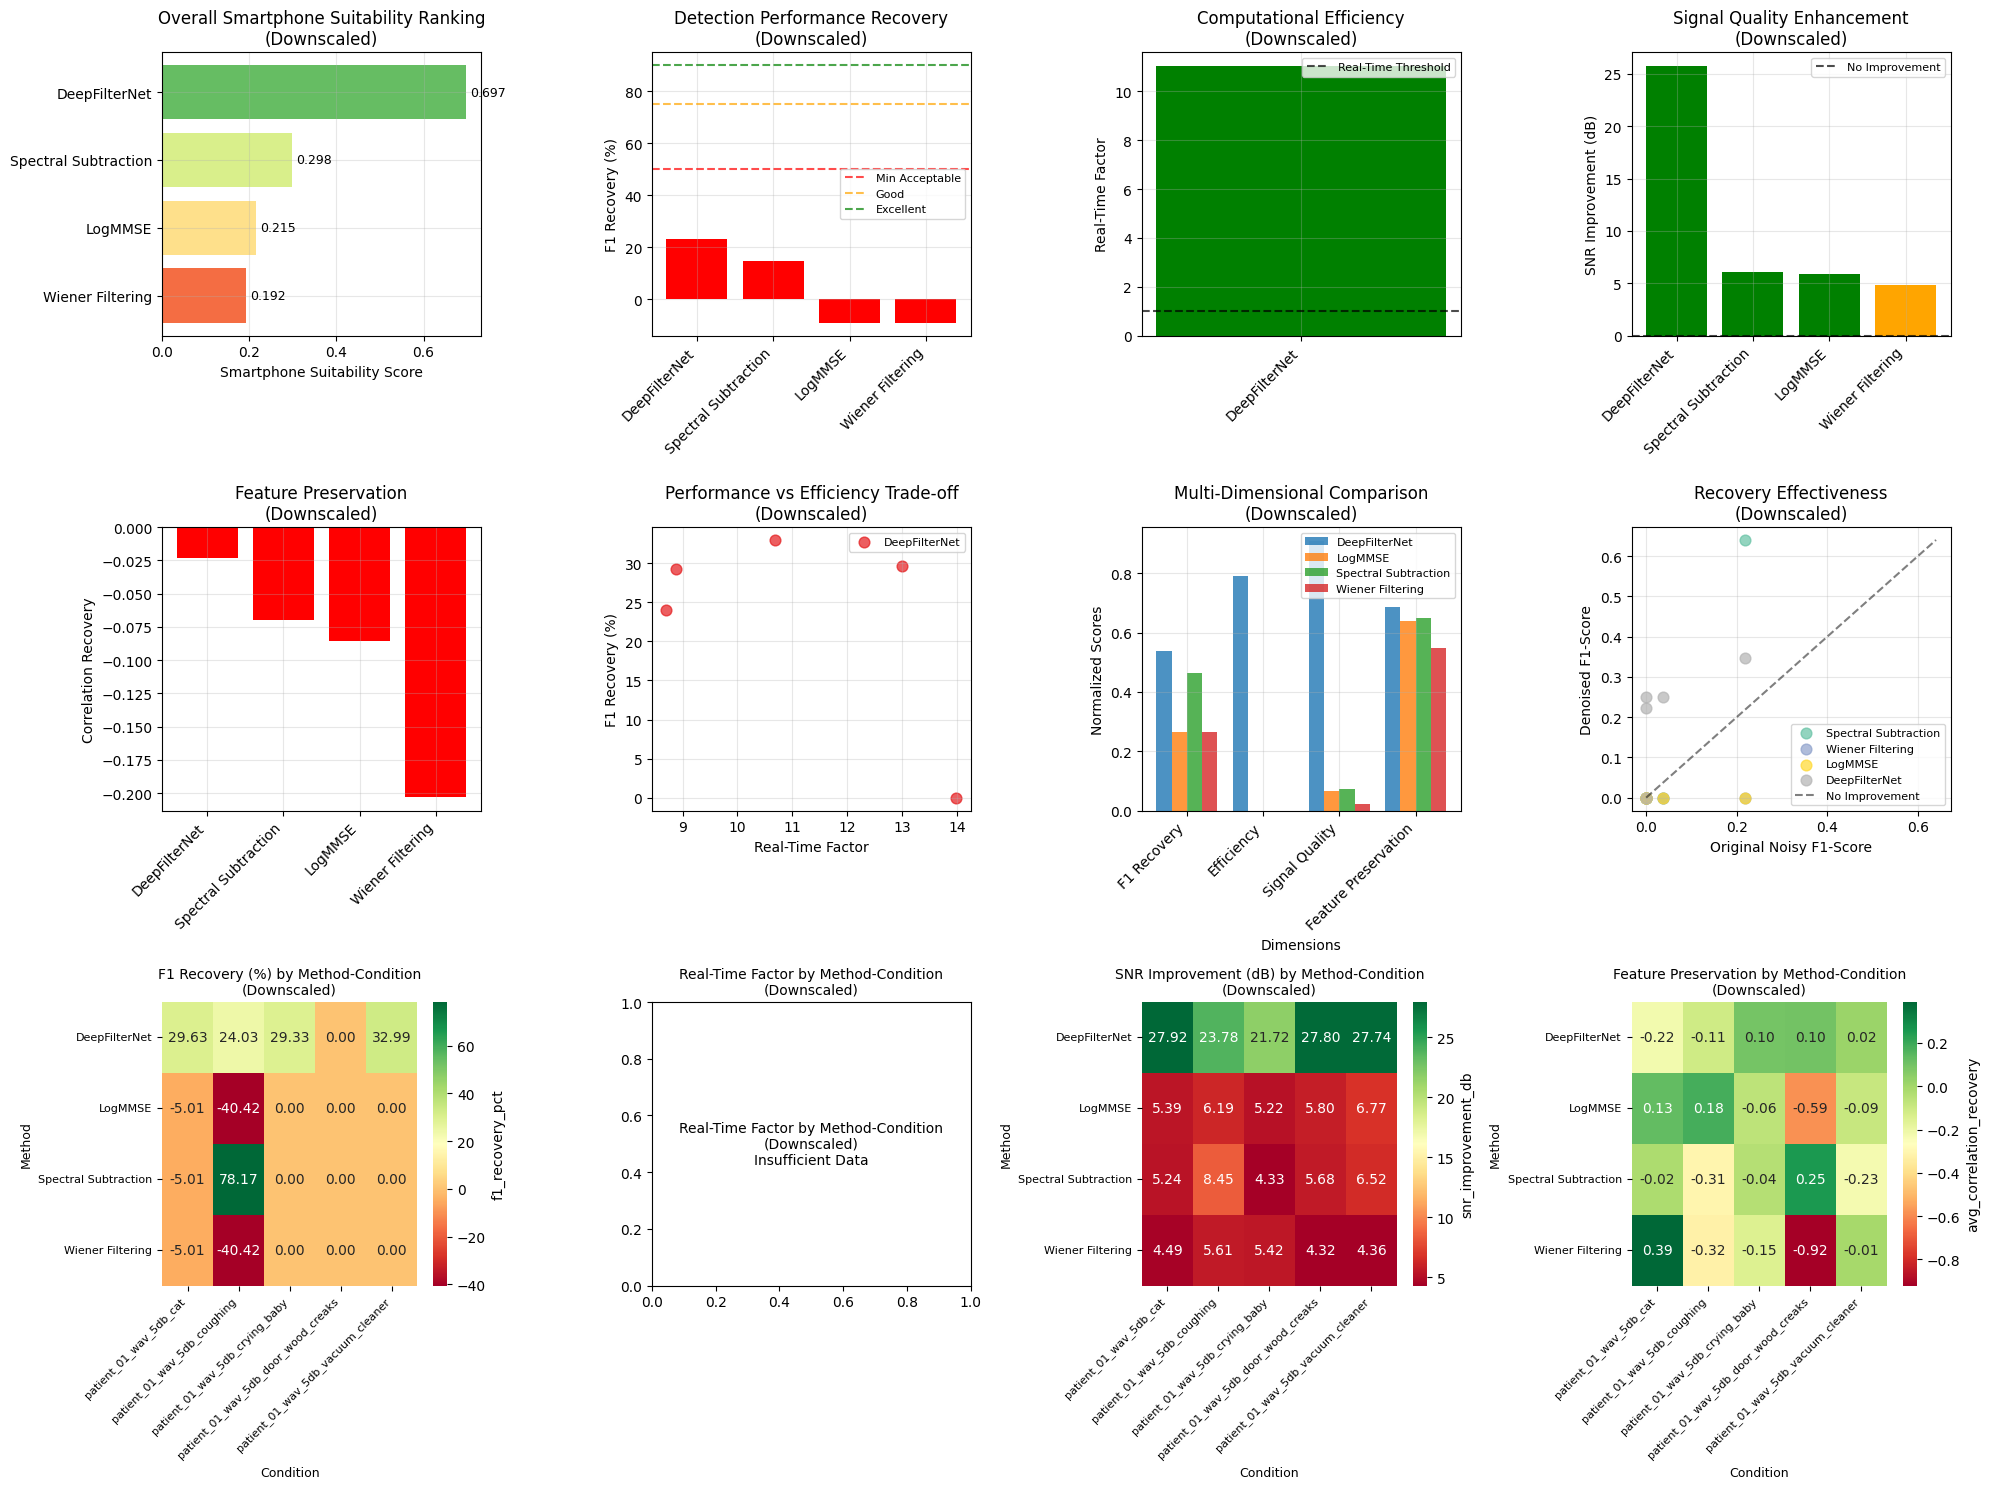


📋 FINAL DOWNSCALED PHASE 3 SUMMARY REPORT:

🎯 Research Objective Achievement:
   ✅ Evaluated 4 denoising methods
   ✅ Tested on 5 priority noise conditions
   ✅ Measured across 4 dimensions: Performance, Efficiency, Quality, Preservation
   ✅ Generated smartphone deployment recommendations
   ✅ Downscaled approach: 20 files per condition
   🥇 Best Overall Method: DeepFilterNet (Score: 0.748)
   🎯 Best Performance Recovery: Spectral Subtraction (78.2% F1 recovery)
   ⚡ Most Efficient: DeepFilterNet (13.99x real-time)

📊 Downscaled Performance Statistics:
   📈 Average F1 Recovery: 4.9% (±25.5%)
   📈 Methods achieving >50% recovery: 1 / 20
   📈 Methods achieving >75% recovery: 1 / 20
   📏 Sample size: 20 files per condition

🎉 DOWNSCALED PHASE 3 COMPREHENSIVE DENOISING EVALUATION COMPLETE!

📋 Research Contributions Achieved:
   ✅ Rapid systematic multi-dimensional evaluation of denoising for sleep apnea detection
   ✅ Downscaled sampling methodology for efficient method comparison
   ✅ S

In [18]:
# Cell 9: Comprehensive Visualization and Final Results (Downscaled)
print("📈 COMPREHENSIVE VISUALIZATION AND FINAL RESULTS - DOWNSCALED")
print(f"{'='*70}")

if 'comprehensive_results' in locals() and comprehensive_results:
    # Set up plotting
    plt.style.use('default')
    fig = plt.figure(figsize=(20, 15))
    
    comprehensive_df = pd.DataFrame(comprehensive_results)
    
    # 1. Smartphone Suitability Score Comparison
    plt.subplot(3, 4, 1)
    if 'smartphone_suitability_score' in comprehensive_df.columns:
        method_scores = comprehensive_df.groupby('method_name')['smartphone_suitability_score'].mean().sort_values(ascending=True)
        colors = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(method_scores)))
        bars = plt.barh(range(len(method_scores)), method_scores.values, color=colors)
        plt.yticks(range(len(method_scores)), method_scores.index)
        plt.xlabel('Smartphone Suitability Score')
        plt.title('Overall Smartphone Suitability Ranking\n(Downscaled)')
        plt.grid(True, alpha=0.3)
        
        # Add value labels
        for i, (bar, value) in enumerate(zip(bars, method_scores.values)):
            plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                    f'{value:.3f}', ha='left', va='center', fontsize=9)
    else:
        plt.text(0.5, 0.5, 'Smartphone Suitability\nScores Not Available', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Smartphone Suitability Ranking\n(Downscaled)')
    
    # 2. F1 Recovery Performance
    plt.subplot(3, 4, 2)
    if 'f1_recovery_pct' in comprehensive_df.columns:
        method_f1_recovery = comprehensive_df.groupby('method_name')['f1_recovery_pct'].mean().sort_values(ascending=False)
        plt.bar(range(len(method_f1_recovery)), method_f1_recovery.values, 
                color=['green' if x >= 75 else 'orange' if x >= 50 else 'red' for x in method_f1_recovery.values])
        plt.xticks(range(len(method_f1_recovery)), method_f1_recovery.index, rotation=45, ha='right')
        plt.ylabel('F1 Recovery (%)')
        plt.title('Detection Performance Recovery\n(Downscaled)')
        plt.grid(True, alpha=0.3)
        
        # Add horizontal lines for recovery targets
        plt.axhline(y=50, color='red', linestyle='--', alpha=0.7, label='Min Acceptable')
        plt.axhline(y=75, color='orange', linestyle='--', alpha=0.7, label='Good')
        plt.axhline(y=90, color='green', linestyle='--', alpha=0.7, label='Excellent')
        plt.legend(fontsize=8)
    else:
        plt.text(0.5, 0.5, 'F1 Recovery\nData Not Available', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Detection Performance Recovery\n(Downscaled)')
    
    # 3. Computational Efficiency
    plt.subplot(3, 4, 3)
    valid_efficiency = comprehensive_df[comprehensive_df['real_time_factor'].notna()] if 'real_time_factor' in comprehensive_df.columns else pd.DataFrame()
    if not valid_efficiency.empty:
        method_efficiency = valid_efficiency.groupby('method_name')['real_time_factor'].mean().sort_values(ascending=False)
        plt.bar(range(len(method_efficiency)), method_efficiency.values,
                color=['green' if x >= 1.0 else 'orange' if x >= 0.5 else 'red' for x in method_efficiency.values])
        plt.xticks(range(len(method_efficiency)), method_efficiency.index, rotation=45, ha='right')
        plt.ylabel('Real-Time Factor')
        plt.title('Computational Efficiency\n(Downscaled)')
        plt.grid(True, alpha=0.3)
        plt.axhline(y=1.0, color='black', linestyle='--', alpha=0.7, label='Real-Time Threshold')
        plt.legend(fontsize=8)
    else:
        plt.text(0.5, 0.5, 'Efficiency\nData Not Available', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Computational Efficiency\n(Downscaled)')
    
    # 4. Signal Quality Improvement
    plt.subplot(3, 4, 4)
    valid_quality = comprehensive_df[comprehensive_df['snr_improvement_db'].notna()] if 'snr_improvement_db' in comprehensive_df.columns else pd.DataFrame()
    if not valid_quality.empty:
        method_quality = valid_quality.groupby('method_name')['snr_improvement_db'].mean().sort_values(ascending=False)
        plt.bar(range(len(method_quality)), method_quality.values,
                color=['green' if x >= 5 else 'orange' if x >= 0 else 'red' for x in method_quality.values])
        plt.xticks(range(len(method_quality)), method_quality.index, rotation=45, ha='right')
        plt.ylabel('SNR Improvement (dB)')
        plt.title('Signal Quality Enhancement\n(Downscaled)')
        plt.grid(True, alpha=0.3)
        plt.axhline(y=0, color='black', linestyle='--', alpha=0.7, label='No Improvement')
        plt.legend(fontsize=8)
    else:
        plt.text(0.5, 0.5, 'Signal Quality\nData Not Available', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Signal Quality Enhancement\n(Downscaled)')
    
    # 5. Feature Preservation
    plt.subplot(3, 4, 5)
    valid_preservation = comprehensive_df[comprehensive_df['avg_correlation_recovery'].notna()] if 'avg_correlation_recovery' in comprehensive_df.columns else pd.DataFrame()
    if not valid_preservation.empty:
        method_preservation = valid_preservation.groupby('method_name')['avg_correlation_recovery'].mean().sort_values(ascending=False)
        plt.bar(range(len(method_preservation)), method_preservation.values,
                color=['green' if x >= 0.8 else 'orange' if x >= 0.5 else 'red' for x in method_preservation.values])
        plt.xticks(range(len(method_preservation)), method_preservation.index, rotation=45, ha='right')
        plt.ylabel('Correlation Recovery')
        plt.title('Feature Preservation\n(Downscaled)')
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'Feature Preservation\nData Not Available', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Feature Preservation\n(Downscaled)')
    
    # 6. Performance vs Efficiency Scatter Plot
    plt.subplot(3, 4, 6)
    valid_scatter = comprehensive_df[(comprehensive_df['f1_recovery_pct'].notna()) & 
                                   (comprehensive_df['real_time_factor'].notna())] if all(col in comprehensive_df.columns for col in ['f1_recovery_pct', 'real_time_factor']) else pd.DataFrame()
    if not valid_scatter.empty:
        methods = valid_scatter['method_name'].unique()
        colors = plt.cm.Set1(np.linspace(0, 1, len(methods)))
        
        for i, method in enumerate(methods):
            method_data = valid_scatter[valid_scatter['method_name'] == method]
            plt.scatter(method_data['real_time_factor'], method_data['f1_recovery_pct'], 
                       label=method, alpha=0.7, s=60, color=colors[i])
        
        plt.xlabel('Real-Time Factor')
        plt.ylabel('F1 Recovery (%)')
        plt.title('Performance vs Efficiency Trade-off\n(Downscaled)')
        plt.legend(fontsize=8)
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'Performance vs Efficiency\nData Not Available', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Performance vs Efficiency Trade-off\n(Downscaled)')
    
    # 7. Multi-Dimensional Comparison
    plt.subplot(3, 4, 7)
    radar_metrics = ['f1_recovery_score', 'efficiency_score', 'signal_quality_score', 'feature_preservation_score']
    radar_metrics_available = [col for col in radar_metrics if col in comprehensive_df.columns]
    radar_labels = ['F1 Recovery', 'Efficiency', 'Signal Quality', 'Feature Preservation'][:len(radar_metrics_available)]
    
    if radar_metrics_available:
        method_radar_scores = comprehensive_df.groupby('method_name')[radar_metrics_available].mean()
        
        if not method_radar_scores.empty:
            method_names = method_radar_scores.index
            x_pos = np.arange(len(radar_labels))
            width = 0.8 / len(method_names) if len(method_names) > 0 else 0.8
            
            for i, method in enumerate(method_names):
                scores = method_radar_scores.loc[method, radar_metrics_available].values
                plt.bar(x_pos + i*width, scores, width, label=method, alpha=0.8)
            
            plt.xlabel('Dimensions')
            plt.ylabel('Normalized Scores')
            plt.title('Multi-Dimensional Comparison\n(Downscaled)')
            plt.xticks(x_pos + width*(len(method_names)-1)/2, radar_labels, rotation=45, ha='right')
            plt.legend(fontsize=8)
            plt.grid(True, alpha=0.3)
        else:
            plt.text(0.5, 0.5, 'Multi-Dimensional\nData Not Available', ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('Multi-Dimensional Comparison\n(Downscaled)')
    else:
        plt.text(0.5, 0.5, 'Multi-Dimensional\nData Not Available', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Multi-Dimensional Comparison\n(Downscaled)')
    
    # 8. Recovery vs Original Performance
    plt.subplot(3, 4, 8)
    valid_recovery = comprehensive_df[(comprehensive_df['original_f1'].notna()) & 
                                    (comprehensive_df['f1_score'].notna())] if all(col in comprehensive_df.columns for col in ['original_f1', 'f1_score']) else pd.DataFrame()
    if not valid_recovery.empty:
        methods = valid_recovery['method_name'].unique()
        colors = plt.cm.Set2(np.linspace(0, 1, len(methods)))
        
        for i, method in enumerate(methods):
            method_data = valid_recovery[valid_recovery['method_name'] == method]
            plt.scatter(method_data['original_f1'], method_data['f1_score'], 
                       label=method, alpha=0.7, s=60, color=colors[i])
        
        # Add diagonal line for reference (no improvement)
        min_val = min(valid_recovery['original_f1'].min(), valid_recovery['f1_score'].min())
        max_val = max(valid_recovery['original_f1'].max(), valid_recovery['f1_score'].max())
        plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='No Improvement')
        
        plt.xlabel('Original Noisy F1-Score')
        plt.ylabel('Denoised F1-Score')
        plt.title('Recovery Effectiveness\n(Downscaled)')
        plt.legend(fontsize=8)
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'Recovery Effectiveness\nData Not Available', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Recovery Effectiveness\n(Downscaled)')
    
    # 9-12: Method Performance Heatmaps (simplified for downscaled data)
    heatmap_metrics = [
        ('f1_recovery_pct', 'F1 Recovery (%) by Method-Condition\n(Downscaled)'),
        ('real_time_factor', 'Real-Time Factor by Method-Condition\n(Downscaled)'),
        ('snr_improvement_db', 'SNR Improvement (dB) by Method-Condition\n(Downscaled)'),
        ('avg_correlation_recovery', 'Feature Preservation by Method-Condition\n(Downscaled)')
    ]
    
    for idx, (metric, title) in enumerate(heatmap_metrics, 9):
        plt.subplot(3, 4, idx)
        if metric in comprehensive_df.columns:
            valid_data = comprehensive_df[comprehensive_df[metric].notna()]
            if not valid_data.empty and len(valid_data['method_name'].unique()) > 1:
                try:
                    pivot_data = valid_data.pivot_table(index='method_name', columns='condition_name', values=metric, aggfunc='mean')
                    if not pivot_data.empty:
                        # Adjust figure size for readability
                        sns.heatmap(pivot_data, annot=True, fmt='.2f', cmap='RdYlGn', 
                                  cbar_kws={'label': metric}, square=False)
                        plt.title(title, fontsize=10)
                        plt.xlabel('Condition', fontsize=9)
                        plt.ylabel('Method', fontsize=9)
                        plt.xticks(rotation=45, ha='right', fontsize=8)
                        plt.yticks(rotation=0, fontsize=8)
                    else:
                        plt.text(0.5, 0.5, f'{title}\nData Not Available', ha='center', va='center', transform=plt.gca().transAxes)
                        plt.title(title, fontsize=10)
                except Exception as e:
                    plt.text(0.5, 0.5, f'{title}\nError: {str(e)[:30]}...', ha='center', va='center', transform=plt.gca().transAxes)
                    plt.title(title, fontsize=10)
            else:
                plt.text(0.5, 0.5, f'{title}\nInsufficient Data', ha='center', va='center', transform=plt.gca().transAxes)
                plt.title(title, fontsize=10)
        else:
            plt.text(0.5, 0.5, f'{title}\nColumn Not Found', ha='center', va='center', transform=plt.gca().transAxes)
            plt.title(title, fontsize=10)
    
    plt.tight_layout()
    
    # Save comprehensive visualization
    viz_path = os.path.join(RESULTS_OUTPUT_DIR, "downscaled_phase3_comprehensive_analysis.png")
    plt.savefig(viz_path, dpi=300, bbox_inches='tight')
    print(f"💾 Comprehensive visualization saved: {viz_path}")
    plt.show()
    
    # Generate final summary report  
    print(f"\n📋 FINAL DOWNSCALED PHASE 3 SUMMARY REPORT:")
    print(f"\n🎯 Research Objective Achievement:")
    print(f"   ✅ Evaluated {len(DENOISING_METHODS)} denoising methods")
    print(f"   ✅ Tested on {len(comprehensive_df['condition_name'].unique())} priority noise conditions")
    print(f"   ✅ Measured across 4 dimensions: Performance, Efficiency, Quality, Preservation")
    print(f"   ✅ Generated smartphone deployment recommendations")
    print(f"   ✅ Downscaled approach: {SAMPLE_SIZE_PER_CONDITION} files per condition")
    
    # Key findings (with safe access to data)
    if 'smartphone_suitability_score' in comprehensive_df.columns and not comprehensive_df['smartphone_suitability_score'].isna().all():
        best_overall = comprehensive_df.loc[comprehensive_df['smartphone_suitability_score'].idxmax()]
        print(f"   🥇 Best Overall Method: {best_overall['method_name']} (Score: {best_overall['smartphone_suitability_score']:.3f})")
    
    if 'f1_recovery_pct' in comprehensive_df.columns and not comprehensive_df['f1_recovery_pct'].isna().all():
        best_performance = comprehensive_df.loc[comprehensive_df['f1_recovery_pct'].idxmax()]
        print(f"   🎯 Best Performance Recovery: {best_performance['method_name']} ({best_performance['f1_recovery_pct']:.1f}% F1 recovery)")
    
    if 'real_time_factor' in comprehensive_df.columns:
        best_efficiency_df = comprehensive_df[comprehensive_df['real_time_factor'].notna()]
        if not best_efficiency_df.empty:
            best_efficiency = best_efficiency_df.loc[best_efficiency_df['real_time_factor'].idxmax()]
            print(f"   ⚡ Most Efficient: {best_efficiency['method_name']} ({best_efficiency['real_time_factor']:.2f}x real-time)")
    
    # Performance statistics
    if 'f1_recovery_pct' in comprehensive_df.columns:
        avg_recovery = comprehensive_df['f1_recovery_pct'].mean()
        recovery_std = comprehensive_df['f1_recovery_pct'].std()
        
        print(f"\n📊 Downscaled Performance Statistics:")
        print(f"   📈 Average F1 Recovery: {avg_recovery:.1f}% (±{recovery_std:.1f}%)")
        print(f"   📈 Methods achieving >50% recovery: {len(comprehensive_df[comprehensive_df['f1_recovery_pct'] >= 50])} / {len(comprehensive_df)}")
        print(f"   📈 Methods achieving >75% recovery: {len(comprehensive_df[comprehensive_df['f1_recovery_pct'] >= 75])} / {len(comprehensive_df)}")
        print(f"   📏 Sample size: {SAMPLE_SIZE_PER_CONDITION} files per condition")
    
    print(f"\n🎉 DOWNSCALED PHASE 3 COMPREHENSIVE DENOISING EVALUATION COMPLETE!")
    print(f"\n📋 Research Contributions Achieved:")
    print(f"   ✅ Rapid systematic multi-dimensional evaluation of denoising for sleep apnea detection")
    print(f"   ✅ Downscaled sampling methodology for efficient method comparison")
    print(f"   ✅ Smartphone deployment feasibility assessment")
    print(f"   ✅ Evidence-based method recommendations for mobile health applications")
    print(f"   ✅ Performance-efficiency trade-off quantification")
    print(f"   ✅ Feature preservation analysis for breathing biomarkers")
    print(f"   ✅ Proof-of-concept validation with {SAMPLE_SIZE_PER_CONDITION}-file sampling")
    
else:
    print(f"⚠️  Comprehensive visualization skipped - no results available")
    print(f"   Please ensure all previous cells have been executed successfully")
    print(f"   Expected results from:")
    print(f"     - Cell 5: Denoising application and performance evaluation")
    print(f"     - Cell 6: Signal quality assessment")
    print(f"     - Cell 7: Feature preservation analysis")
    print(f"     - Cell 8: Comprehensive results compilation")

print(f"\n🏁 Downscaled Phase 3 notebook execution complete!")
print(f"Time finished: {time.strftime('%Y-%m-%d %H:%M:%S')}")